<center><h1>Kaggle

In [1]:
import pandas as pd
import numpy as np
# import matplotlib.pyplot as plt
# import plotly.graph_objects as go
# import plotly.express as px
from sklearn.metrics import mean_absolute_percentage_error as mape # usage : print(mape(pred, observed))

import datetime

path = 'C:/Users/sebir/Desktop/M2 Toulouse/Défi IA/'

# Import data

In [2]:
# Training set, X
X = pd.read_csv(path + 'X_station_train.csv',
                parse_dates=['date'],
                infer_datetime_format=True)
X.columns = ['number_sta', 'date', 'wind_speed', 'temperature', 'dew_point_temperature', 'humidity', 'wind_direction', 'precipitation', 'Id']

# Training set, Y
Y = pd.read_csv(path + 'Y_train.csv',
                parse_dates=['date'],
                infer_datetime_format=True)

# Preprocess data

We have to group the data by data in order to have something comparable with `Y`

In [3]:
X['day'] = X['date'].apply(lambda x: x.date())

In [4]:
X_agg = X.copy()
X_agg = X_agg.groupby(by = ['day', 'number_sta'], as_index = False).agg({
    "number_sta"            : "first",
    "wind_speed"            : "median",
    "temperature"           : "median",
    "dew_point_temperature" : "median",
    "humidity"              : "median",
    "wind_direction"        : "median",
    "precipitation"         : "sum"
})

# Fill in the gaps
We have to find a way to fill the gaps in the data. Suggested ways:
* fill the mean or the median, e.g., for a given variable
    * take the general median of the whole training dataset (not working, Martin says)
    * take the median of the month (not working, Martin says)
* take the value from the nearest neighbour
* interpolate the value from nearest neighbours

,lat,lon,height_sta
number_sta,,,
86118001,46.477,0.985,120.0
86149001,46.917,0.025,60.0
56081003,48.050,-3.660,165.0
53215001,47.790,-0.710,63.0
22135001,48.550,-3.380,148.0
...,...,...,...
86137003,47.035,0.098,96.0
86165005,46.412,0.841,153.0
86273001,46.464,1.042,121.0


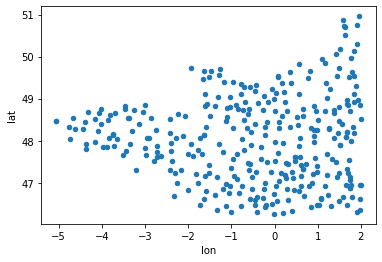

In [5]:
stations = pd.read_csv(path + 'stations_coordinates.csv')
stations.set_index('number_sta', inplace = True)
display(stations)
stations.plot(x = 'lon', y = 'lat', kind = 'scatter');

## Fill with data from nearest(s) neighbour(s)
We can firstly try to take the missing data from the nearest neighbour, or the next nearest neighbours in case the data is not available there. For all the stations, we have to compute the distance to all the other stations and sort them according to this distance.

Here, using directly the `lon` and `lat` coordinates as `x`, `y`, we assume that Earth's curve is small enough on this area. Could be assessed later on.

We also only take into account the spatial data and not the altitude, which may be an important information.

In [6]:
from scipy.spatial import distance_matrix
distances = pd.DataFrame(distance_matrix(stations[['lon', 'lat']],
                                         stations[['lon', 'lat']]),
                         index=stations.index,
                         columns=stations.index)

nearestNeighbours = pd.DataFrame(index = stations.index,
                                 columns = range(len(stations)))
for station in nearestNeighbours.index:
    nearestNeighbours.loc[station] = distances.loc[station].sort_values().index
nearestNeighbours.drop(0, axis = 1, inplace = True)

Let's make a function that, given the DataFrame and the column to fill, returns a Series with NAs filled:
1. Find the index of NA values in this column
2. For each NA value found: (nearest neighbour value - could do interpolation)
    1. Find corresponding number_sta
    2. Find nearest neighbours of this number_sta
    3. Iterate over nearest neighbours, try to find a value for this day and this column

In [ ]:
# # Old version, working but very slow
# from tqdm.notebook import tqdm

# # We can make a function that for a given
# def fillNAs(df, columnToFill, method = 'nearestNeighbour'):
    
#     filledColumn = df[columnToFill].copy()
#     indexesToFill = df.loc[pd.isna(df[columnToFill]), :].index
    
#     if method == 'nearestNeighbour':
#         """The DataFrame 'nearestNeighbours' must have been computed
#         and must be callable."""
        
#         for idx in tqdm(indexesToFill):
#             # Get the number of the station and its nearest neighbours
#             number_sta = X_agg.loc[idx].number_sta
#             nearests = nearestNeighbours.loc[number_sta]

#             # Look for a valid value among the neighbours
#             for i in range(1, len(nearests)-1):
#                 try:
#                     value = df.loc[(df['day'] == df.loc[idx].day) & (df['number_sta'] == nearests[i]), columnToFill].to_list()[0]
#                     if not np.isnan(value):
#                         break
#                 except:
#                     pass
        
#             filledColumn.loc[idx] = value
        
#     else:
#         print(f"'{method}' is not a valid method.")
    
#     return filledColumn

In [7]:
from tqdm.notebook import tqdm

# We can make a function that for a given
def fillNAs(df, columnToFill, method = 'nearestNeighbour'):
    """Fill the NAs in column 'columnToFill' from DataFrame df with values
    found from same day on nearest neighbour with a valid value.
    Returns the column with the NAs filled."""
    
    dfReindexed = df.set_index(['day', 'number_sta'])
    
    filledColumn = df[columnToFill].copy()
    indexesToFill = df.loc[pd.isna(df[columnToFill]), :].index
    
    if method == 'nearestNeighbour':
        """The DataFrame 'nearestNeighbours' must have been computed
        and must be callable."""
        
        for idx in tqdm(indexesToFill):
            # Get the number of the station and its nearest neighbours
            number_sta = df.loc[idx].number_sta
            nearests = nearestNeighbours.loc[number_sta]

            # Look for a valid value among the neighbours
            for i in range(1, len(nearests)-1):
                try:
                    value = dfReindexed.loc[(df.loc[idx].day, nearests[i]), columnToFill]
                    if not np.isnan(value):
                        break
                except:
                    pass
        
            filledColumn.loc[idx] = value
        
    else:
        print(f"'{method}' is not a valid method.")
    
    return filledColumn

In [8]:
X_agg_filled = X_agg.copy()
X_agg_filled['wind_speed'] = fillNAs(X_agg, 'wind_speed')

  0%|          | 0/72536 [00:00<?, ?it/s]

In [9]:
X_agg.head()

,day,number_sta,wind_speed,temperature,dew_point_temperature,humidity,wind_direction,precipitation
0,2016-01-01,14066001,3.695,281.325,278.625,90.15,142.0,0.2
1,2016-01-01,14126001,NaN,280.725,279.650,99.00,NaN,0.5
2,2016-01-01,14137001,5.830,281.155,278.905,93.50,140.0,0.0
3,2016-01-01,14216001,5.010,280.630,278.815,91.25,155.5,0.6
4,2016-01-01,14296001,NaN,279.495,NaN,NaN,NaN,0.2


In [10]:
X_agg_filled.head()

,day,number_sta,wind_speed,temperature,dew_point_temperature,humidity,wind_direction,precipitation
0,2016-01-01,14066001,3.695,281.325,278.625,90.15,142.0,0.2
1,2016-01-01,14126001,5.230,280.725,279.650,99.00,NaN,0.5
2,2016-01-01,14137001,5.830,281.155,278.905,93.50,140.0,0.0
3,2016-01-01,14216001,5.010,280.630,278.815,91.25,155.5,0.6
4,2016-01-01,14296001,4.200,279.495,NaN,NaN,NaN,0.2


# Trial with Random Forest

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_agg, Y['Ground_truth'], test_size = 0.3)

In [ ]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators = 200)
rf.fit(X_train, y_train)

In [ ]:
y_predict = rf.predict(X_test)
print(f"Score: {mape(y_predict, y_test)}")

# Submission

In [ ]:
X_test = pd.read_csv(path + 'X_station_test.csv')
X_test